In [48]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import time
from sklearn.metrics import accuracy_score, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn import preprocessing
import math
import scaleogram as scg 

In [2]:
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')

In [4]:
confirmed_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/26/21,4/27/21,4/28/21,4/29/21,4/30/21,5/1/21,5/2/21,5/3/21,5/4/21,5/5/21
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,59015,59225,59370,59576,59745,59939,60122,60300,60563,60797
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,130606,130736,130859,130977,131085,131185,131238,131276,131327,131419
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,121112,121344,121580,121866,122108,122311,122522,122717,122999,123272
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,13083,13121,13148,13198,13232,13232,13282,13295,13316,13340
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,25710,25942,26168,26431,26652,26815,26993,27133,27284,27529


In [6]:
confirmed_df.loc[confirmed_df["Country/Region"]=="US"]

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/26/21,4/27/21,4/28/21,4/29/21,4/30/21,5/1/21,5/2/21,5/3/21,5/4/21,5/5/21
250,NaN,US,40.0,-100.0,1,1,2,2,5,5,...,32124869,32175725,32230850,32289049,32346971,32392274,32421641,32472201,32512934,32557444


In [154]:
# US cases records
df_confirmed_us = confirmed_df.loc[confirmed_df["Country/Region"]=="US"]
df_confirmed_us = df_confirmed_us.drop(columns=['Province/State', 'Lat','Long','Country/Region'])
df_confirmed_us = df_confirmed_us.transpose()
column_head = int(df_confirmed_us.columns[0])
df_confirmed_us = df_confirmed_us.rename(columns={column_head: "US"})
df_confirmed_us.index = pd.to_datetime(df_confirmed_us.index)
df_conf_daily_us = df_confirmed_us.diff()
df_conf_daily_us['US'] = df_conf_daily_us['US'].replace(np.nan, 1)
df_conf_daily_us = df_conf_daily_us.loc[:'2021-02-23']
df_conf_daily_us

,US
2020-01-22,1.0
2020-01-23,0.0
2020-01-24,1.0
2020-01-25,0.0
2020-01-26,3.0
...,...
2021-02-19,79297.0
2021-02-20,71525.0
2021-02-21,57080.0
2021-02-22,56220.0


In [155]:
data = df_conf_daily_us.values.squeeze()
N = data.size
print("Nb of samples of data:", N)

t0 = 2020; dt = 1/365
year = t0 + np.arange(1,len(data))*dt

Nb of samples of data: 399


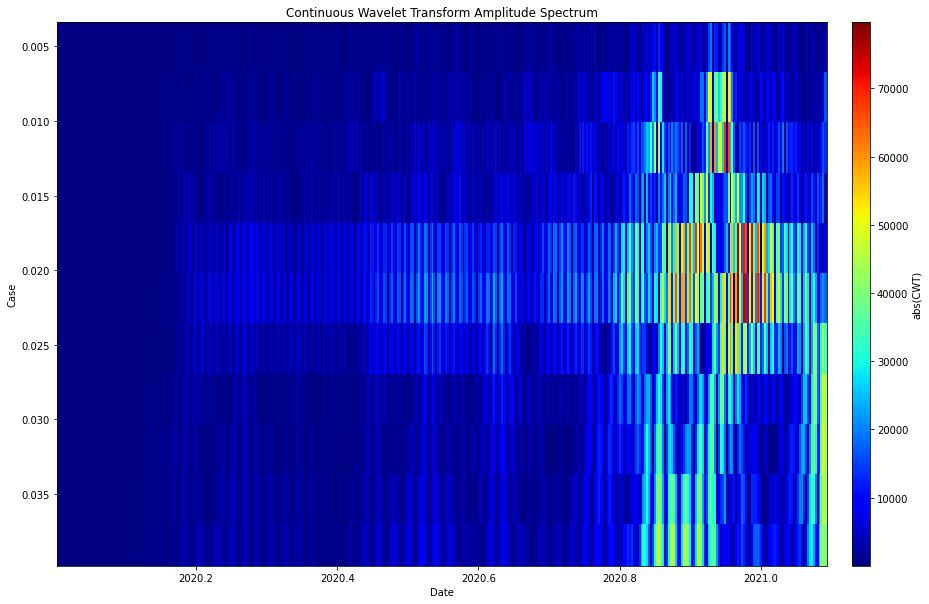

In [158]:
import scaleogram as scg

# choose default wavelet function 
scg.set_default_wavelet('morl')
scales = np.arange(1, 12)
ax = scg.cws(year, data, scales, figsize=(15,10), coi = False, ylabel="Case", xlabel='Date')
ax.figure.savefig("CWT.png")

In [130]:
df_log = pd.DataFrame()
df_log['log return'] = np.log(df_conf_daily_us['US'].shift(-1)/df_conf_daily_us['US']) 
df_log

C:\Users\dell\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,log return
2020-01-22,-inf
2020-01-23,inf
2020-01-24,-inf
2020-01-25,inf
2020-01-26,-inf
...,...
2021-02-19,-0.103153
2021-02-20,-0.225593
2021-02-21,-0.015181
2021-02-22,0.251040


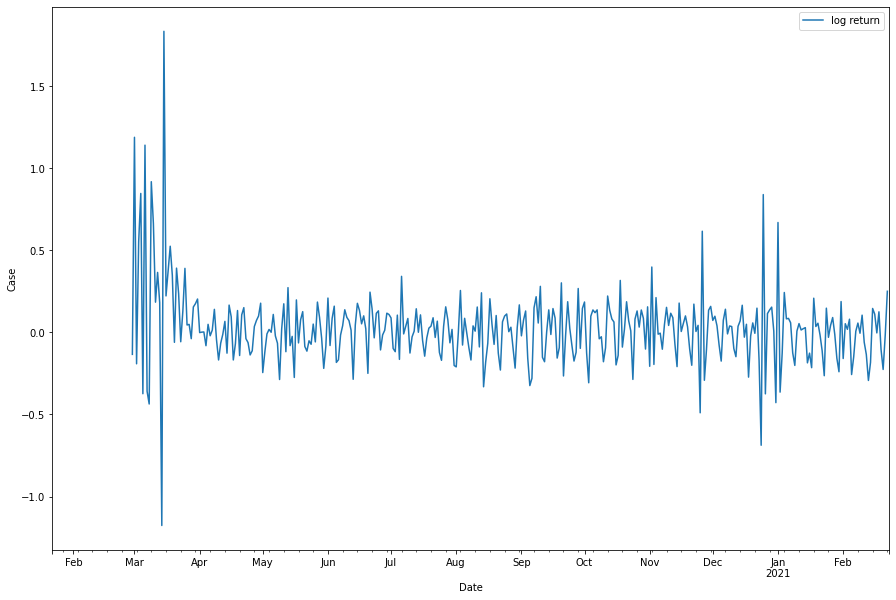

In [134]:
plot = df_log.plot(figsize=(15,10),xlabel="Date",ylabel="Case")
fig = plot.get_figure()
fig.savefig("log_retun.png")

In [177]:
data = df_conf_daily_us.values.squeeze()
scales = np.arange(1,2)
coeff, freq = pywt.cwt(data, scales, 'morl')
wav_data = coeff.squeeze()
df_com = df_log
df_com["wavelet"]=wav_data
df_com

,log return,wavelet
2020-01-22,-inf,-0.116855
2020-01-23,inf,-0.009930
2020-01-24,-inf,0.014516
2020-01-25,inf,0.239020
2020-01-26,-inf,-0.254399
...,...,...
2021-02-19,-0.103153,-1014.779802
2021-02-20,-0.225593,-2948.932462
2021-02-21,-0.015181,1013.274148
2021-02-22,0.251040,3479.905722


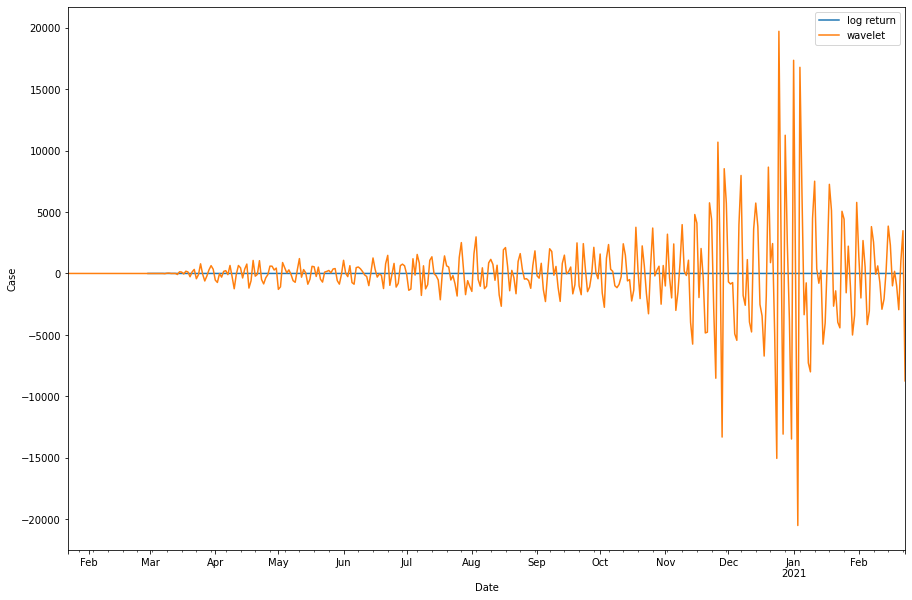

In [178]:
plot = df_com.plot(figsize=(15,10),xlabel="Date",ylabel="Case")
fig = plot.get_figure()
#fig.savefig("log_retun+wav.png")

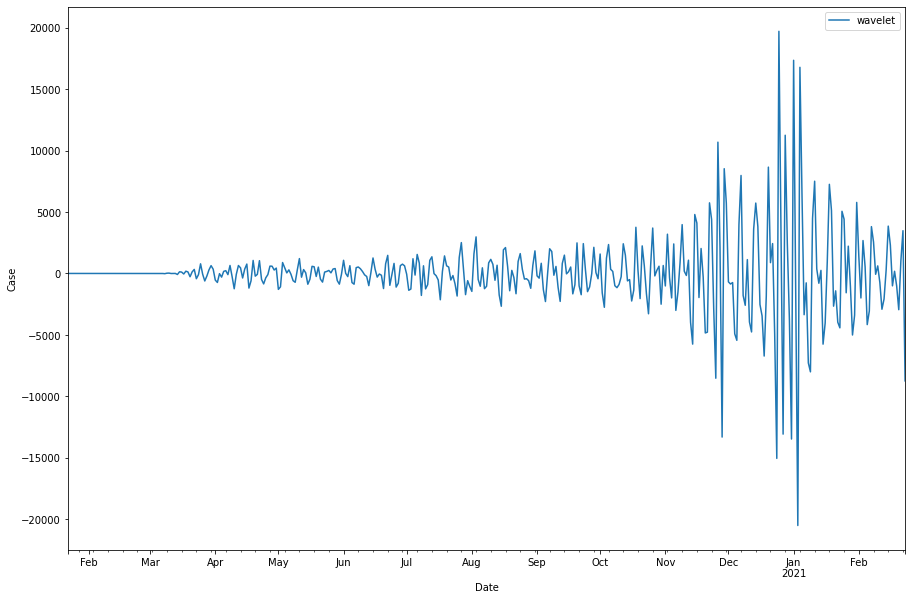

In [180]:
plot = df_com[["wavelet"]].plot(figsize=(15,10),xlabel="Date",ylabel="Case")
fig = plot.get_figure()
#fig.savefig("wav.png")

# SVM

In [184]:
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import pandas as pd 
import random
import math
import time
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import datetime
import operator 
import numpy as np
#plt.style.use('fivethirtyeight')
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [181]:
df_wav = df_com[["wavelet"]]
dates = df_wav.index
dates

DatetimeIndex(['2020-01-22', '2020-01-23', '2020-01-24', '2020-01-25',
               '2020-01-26', '2020-01-27', '2020-01-28', '2020-01-29',
               '2020-01-30', '2020-01-31',
               ...
               '2021-02-14', '2021-02-15', '2021-02-16', '2021-02-17',
               '2021-02-18', '2021-02-19', '2021-02-20', '2021-02-21',
               '2021-02-22', '2021-02-23'],
              dtype='datetime64[ns]', length=399, freq=None)

In [186]:
days_since_1_22 = np.array([i for i in range(len(dates))]).reshape(-1, 1)
wav_cases = np.array(df_wav["wavelet"]).reshape(-1, 1)

# slightly modify the data to fit the model better (regression models cannot pick the pattern)
X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(days_since_1_22, wav_cases, test_size=0.2, shuffle=False)

In [192]:
y_train_confirmed

array([[-1.16855121e-01],
       [-9.93041435e-03],
       [ 1.45160932e-02],
       [ 2.39019716e-01],
       [-2.54398537e-01],
       [-3.56767069e-01],
       [ 4.69044229e-01],
       [-9.14352293e-02],
       [ 1.08626012e-01],
       [-1.33111910e-01],
       [-2.20875153e-01],
       [ 5.91223780e-01],
       [-3.58526041e-01],
       [-3.66634877e-01],
       [ 4.74378944e-01],
       [-1.04092113e-01],
       [-1.28544638e-01],
       [ 1.16740330e-01],
       [ 1.26674392e-02],
       [ 1.15014190e-01],
       [-1.16807337e-01],
       [-4.51908088e-03],
       [-4.53816725e-03],
       [-1.16783445e-01],
       [ 1.16811604e-01],
       [ 6.32197608e-03],
       [-1.84479499e-03],
       [-3.61872218e-03],
       [ 1.26811799e-02],
       [ 2.37218035e-01],
       [-2.46331735e-01],
       [-2.46321990e-01],
       [ 2.36979302e-01],
       [ 1.07184660e-02],
       [ 2.25369358e-03],
       [ 1.03304723e-01],
       [-8.59860053e-02],
       [ 8.26827345e-01],
       [ 7.3

Model fitting time:  3.0920 seconds.
Prediction time:  0.0013 seconds.
MAE: 4544.114400530442
MSE: 40511028.374161705


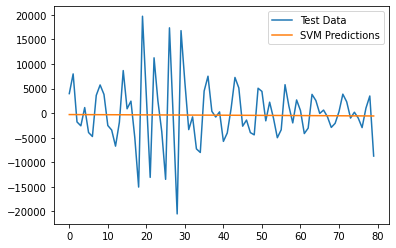

In [188]:
# SVM 

svm_confirmed = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1,degree=3, C=0.1)
tic1 = time.perf_counter()
svm_confirmed.fit(X_train_confirmed, y_train_confirmed)
toc2 = time.perf_counter()
print(f"Model fitting time: {toc2 - tic1: 0.4f} seconds.")
#svm_pred = svm_confirmed.predict(future_forcast)


# check against testing data
tic1 = time.perf_counter()
svm_test_pred = svm_confirmed.predict(X_test_confirmed)
toc2 = time.perf_counter()
print(f"Prediction time: {toc2 - tic1: 0.4f} seconds.")
plt.plot(y_test_confirmed)
plt.plot(svm_test_pred)
plt.legend(['Test Data', 'SVM Predictions'])
print('MAE:', mean_absolute_error(svm_test_pred, y_test_confirmed))
print('MSE:',mean_squared_error(svm_test_pred, y_test_confirmed))

In [189]:
# Calculate the RMSE and accuracy 
# RMSE 
print("Before normalized:")
MSE = np.square(np.subtract(y_test_confirmed, svm_test_pred)).mean() 
RMSE = math.sqrt(MSE)
print("RMSE: ", RMSE)

# R2 score
acc_r2 = r2_score(y_test_confirmed, svm_test_pred)
print("R2: ", acc_r2)

print("After normalized")
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(y_test_confirmed.reshape(-1,1))
pred_scaled = min_max_scaler.fit_transform(svm_test_pred.reshape(-1,1))
MSE = np.square(np.subtract(x_scaled, pred_scaled)).mean() 
RMSE = math.sqrt(MSE)
print("RMSE: ", RMSE)

# R2 score
acc_r2 = r2_score(x_scaled, pred_scaled)
print("R2: ", acc_r2)

print("========================")

# Accuracy
acc = 100 - mean_absolute_percentage_error(y_test_confirmed, svm_test_pred)
print(f"Accuracy: {acc: 0.4f} %.")

#MAPE
mape = mean_absolute_percentage_error(y_test_confirmed, svm_test_pred)
print(f"MAPE: {mape: 0.4f} %.")

Before normalized:
RMSE:  6368.346358132208
R2:  -0.0035414297643110437
After normalized
RMSE:  0.3273963276408738
R2:  -3.2921590855414022
Accuracy:  98.8431 %.
MAPE:  1.1569 %.


# LSTM

In [197]:
import pandas as pd
from sklearn.metrics import mean_squared_error,  r2_score
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy as np
import time

In [194]:
# date-time parsing function for loading the dataset
def parser(x):
    return pd.datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

In [199]:
# load dataset
series = df_wav["wavelet"]

# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
bound = int(-len(series)*0.2)
train, test = supervised_values[0:bound], supervised_values[bound:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
tic1 = time.perf_counter()
lstm_model = fit_lstm(train_scaled, 1, 150, 4)
toc2 = time.perf_counter()
print(f"Model fitting time: {toc2 - tic1: 0.4f} seconds.")

# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)


tic1 = time.perf_counter()
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions.append(yhat)
    expected = raw_values[len(train) + i + 1]
    print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
toc2 = time.perf_counter()
print(f"Prediction time: {toc2 - tic1: 0.4f} seconds.")

Model fitting time:  63.0175 seconds.
Month=1, Predicted=-2842.717891, Expected=7970.332125
Month=2, Predicted=-3654.065965, Expected=-1794.984597
Month=3, Predicted=-8333.181303, Expected=-2590.000685
Month=4, Predicted=-5959.179842, Expected=1125.484296
Month=5, Predicted=-3392.624093, Expected=-3947.366201
Month=6, Predicted=-4061.408365, Expected=-4759.025044
Month=7, Predicted=-2378.934953, Expected=3607.403403
Month=8, Predicted=998.551887, Expected=5725.893818
Month=9, Predicted=280.330310, Expected=3806.831294
Month=10, Predicted=-409.492312, Expected=-2527.464966
Month=11, Predicted=552.627561, Expected=-3448.842692
Month=12, Predicted=1955.702273, Expected=-6720.137702
Month=13, Predicted=2791.841620, Expected=-1857.805632
Month=14, Predicted=1685.165827, Expected=8650.003863
Month=15, Predicted=4959.879073, Expected=879.020086
Month=16, Predicted=873.698676, Expected=2430.722230
Month=17, Predicted=1247.660909, Expected=-4962.114812
Month=18, Predicted=855.336346, Expected=-

In [200]:
# RMSE 
print("Before normalized:")
MSE = np.square(np.subtract(raw_values[bound:], predictions)).mean() 
RMSE = math.sqrt(MSE)
print("RMSE: ", RMSE)
print("After normalized")
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(raw_values[bound:].reshape(-1,1))
pred_scaled = min_max_scaler.fit_transform(np.array(predictions).reshape(-1,1))
MSE = np.square(np.subtract(x_scaled, pred_scaled)).mean() 
RMSE = math.sqrt(MSE)
print("RMSE: ", RMSE)

print("===================")
# R2 score
acc_r2 = r2_score(list(raw_values[bound:]), predictions)
print("R2: ", acc_r2)

# Accuracy
acc = 100 - mean_absolute_percentage_error(list(raw_values[bound:]), predictions)
print(f"Accuracy: {acc: 0.4f} %.")

#MAPE
mape = mean_absolute_percentage_error(list(raw_values[bound:]), predictions)
print(f"MAPE: {mape: 0.4f} %.")

Before normalized:
RMSE:  8135.764966199306
After normalized
RMSE:  0.24606111661795133
R2:  -0.627220036688642
Accuracy:  96.8499 %.
MAPE:  3.1501 %.


# ARIMA

In [210]:
# 80% training set and 20% test set
bound = int(len(df_wav.index)*0.8)-1
train, test = df_wav.loc[:df_wav.index[bound]], df_wav.loc[df_wav.index[bound+1]:]

In [217]:
train.describe()

,wavelet
count,319.000000
mean,-20.573008
std,1831.998233
min,-13311.537858
25%,-582.868568
50%,-0.004538
75%,535.295789
max,10680.350658


In [218]:
test.describe()

,wavelet
count,80.000000
mean,-6.079765
std,6393.673115
min,-20505.433683
25%,-3366.810521
50%,-402.886789
75%,3511.780142
max,19699.845507


In [204]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [212]:
# model selection

warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train["wavelet"],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:5682.858103613564
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:5455.687298638262
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:5688.374377681279
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:5296.153798105079
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:5461.830463693021
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:5446.62668847756
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:5362.26934369023
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:5247.527419156951
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:5555.296178046667
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:5326.367810682712
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:5579.349010031772
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:5178.5925317879155
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:5393.916345300593
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:5328.266415589628
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:5310.654107984339
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:5162.6172733914245
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:5907.231272255272
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:5676.660330996052
ARIMA(0, 1

In [214]:
# Choose the best model with lowest AIC score

tic1 = time.perf_counter()
mod = sm.tsa.statespace.SARIMAX(train["wavelet"],
                                order=(0, 0, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

toc2 = time.perf_counter()

print(f"Model fitting time: {toc2 - tic1: 0.4f} seconds.")
print(results.summary().tables[1])

Model fitting time:  2.3773 seconds.
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9742      0.011    -85.415      0.000      -0.997      -0.952
ar.S.L12      -0.3487      0.067     -5.216      0.000      -0.480      -0.218
ma.S.L12      -0.9290      0.050    -18.571      0.000      -1.027      -0.831
sigma2      2.456e+06   1.09e+05     22.492      0.000    2.24e+06    2.67e+06


In [215]:
# Validate the forecasting

tic1 = time.perf_counter()
pred = results.get_prediction(start=pd.to_datetime('12/06/2020'), end=pd.to_datetime('02/23/2021'), dynamic=False)
toc2 = time.perf_counter()

print(f"Prediction time: {toc2 - tic1: 0.4f} seconds.")
pred_ci = pred.conf_int()

Prediction time:  0.1569 seconds.


In [216]:
# Calculate the RMSE and accuracy 

actual_cases = test["wavelet"]

# RMSE 
print("Before normalized:")
MSE = np.square(np.subtract(actual_cases.values, pred.predicted_mean.values)).mean() 
RMSE = math.sqrt(MSE)
print("RMSE: ", RMSE)
print("After normalized")
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(actual_cases.values.reshape(-1,1))
pred_scaled = min_max_scaler.fit_transform(pred.predicted_mean.values.reshape(-1,1))
MSE = np.square(np.subtract(x_scaled, pred_scaled)).mean() 
RMSE = math.sqrt(MSE)
print("RMSE: ", RMSE)

print("=========================")

# R2 score
acc_r2 = r2_score(actual_cases,pred.predicted_mean)
print("R2: ", acc_r2)

# Accuracy
acc = 100 - mean_absolute_percentage_error(actual_cases,pred.predicted_mean)
print(f"Accuracy: {acc: 0.4f} %.")

#MAPE
mape = mean_absolute_percentage_error(actual_cases,pred.predicted_mean)
print(f"MAPE: {mape: 0.4f} %.")

Before normalized:
RMSE:  6377.605679083817
After normalized
RMSE:  0.27157703642468156
R2:  -0.007574960052157298
Accuracy:  98.9401 %.
MAPE:  1.0599 %.
